In [289]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics.pairwise import haversine_distances

In [290]:
#ANGI ANTALL CLUSTERS KJØRINGEN SKAL HA
antall_clusters = 25

### K-means algorithm for generating clusters

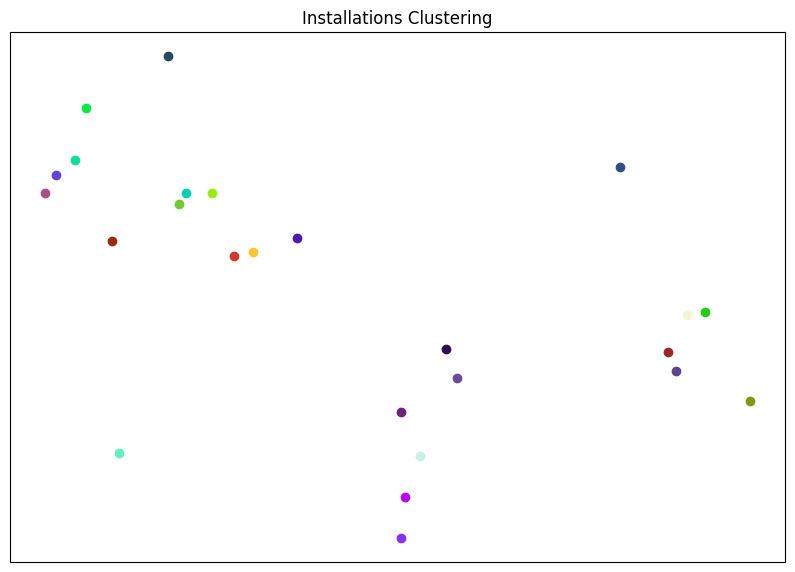

Cluster 17: ['APT'], Total Cargo_per_visit: 18.0
Cluster 11: ['ASL'], Total Cargo_per_visit: 25.0
Cluster 6: ['DAB'], Total Cargo_per_visit: 40.0
Cluster 15: ['DSA'], Total Cargo_per_visit: 29.0
Cluster 8: ['DSS'], Total Cargo_per_visit: 29.0
Cluster 9: ['GFA'], Total Cargo_per_visit: 32.0
Cluster 25: ['GFB'], Total Cargo_per_visit: 22.0
Cluster 19: ['GFC'], Total Cargo_per_visit: 25.0
Cluster 13: ['KVB'], Total Cargo_per_visit: 14.0
Cluster 1: ['MID'], Total Cargo_per_visit: 14.0
Cluster 5: ['NLN'], Total Cargo_per_visit: 25.0
Cluster 14: ['OSC'], Total Cargo_per_visit: 18.0
Cluster 18: ['OSE'], Total Cargo_per_visit: 36.0
Cluster 7: ['OSO'], Total Cargo_per_visit: 14.0
Cluster 4: ['OSS'], Total Cargo_per_visit: 18.0
Cluster 21: ['STA'], Total Cargo_per_visit: 25.0
Cluster 16: ['STB'], Total Cargo_per_visit: 29.0
Cluster 3: ['STC'], Total Cargo_per_visit: 29.0
Cluster 22: ['TEN'], Total Cargo_per_visit: 18.0
Cluster 12: ['TEQ'], Total Cargo_per_visit: 18.0
Cluster 2: ['TRB'], Total Ca

In [291]:
data = pd.read_csv('clustering_input.csv', delimiter=';')
coordinates = data[['Latitude', 'Longitude']]

clusters = []
cluster_summary = {}

def cluster_with_demand_constraint(num_clusters, data):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)
    
    labels = kmeans.labels_

    clustered_installations = {}
    for i, label in enumerate(labels):
        if label not in clustered_installations:
            clustered_installations[label] = []
        clustered_installations[label].append(data.index[i])

    return labels, clustered_installations

def generate_cluster_colors(num_clusters):
    np.random.seed(42)
    colors = np.random.rand(num_clusters, 3)
    return colors

def plot_clusters_on_map(data, labels, colors):
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for i, label in enumerate(labels):
        lat, lon = data.iloc[i]
        color = colors[label]
        ax.scatter(lon, lat, color=color, marker='o', transform=ccrs.PlateCarree(), zorder=5)
    ax.coastlines()
    plt.title('Installations Clustering')
    plt.show()

def print_clustered_installations(clustered_installations, data):
    cluster_data = {'platform': [], 'visits': []}
    
    for cluster, installations in clustered_installations.items():
        ids = [data.iloc[i]['ID'] for i in installations]
        
        max_visits = max(data.iloc[i]['Visits_per_week'] for i in installations)
        cargo_sum = sum(data.iloc[i]['Cargo_per_visit'] * data.iloc[i]['Visits_per_week'] / max_visits for i in installations)
        
        cluster_data['platform'].append(''.join(ids))
        cluster_data['visits'].append(round(max_visits, 2))
        
        print(f"Cluster {cluster + 1}: {ids}, Total Cargo_per_visit: {round(cargo_sum,2)}")
        clusters.append(ids)

        cluster_summary[cluster + 1] = {'platform': ''.join(ids), 'avg_q': round(cargo_sum,2)}
    
    return cluster_data

def save_cluster_summary_to_csv(cluster_summary, filename='output_platforms_demand.csv'):
    df = pd.DataFrame.from_dict(cluster_summary, orient='index')
    df.to_csv(filename, index=False, sep=';')

def save_cluster_data_to_csv(cluster_data, filename='output_platforms_visits.csv'):
    df = pd.DataFrame(cluster_data)
    df.to_csv(filename, index=False, sep=';')

def main():
    num_clusters = antall_clusters
    labels, clustered_installations = cluster_with_demand_constraint(num_clusters, coordinates)
    colors = generate_cluster_colors(num_clusters)
    plot_clusters_on_map(coordinates, labels, colors)
    cluster_data = print_clustered_installations(clustered_installations, data)
    save_cluster_data_to_csv(cluster_data)
    save_cluster_summary_to_csv(cluster_summary)

if __name__ == "__main__":
    main()


### Create distance matrix based on the generated clusters

In [292]:
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  
    return distance

clusters_list = [['MON']]
for cluster in clusters:
    clusters_list.append(cluster)

installations = pd.read_csv('distance_matrix_input.csv', delimiter=';')

cluster_centroids = []
cluster_names = []
for cluster in clusters_list:
    centroid_lat = installations.loc[installations['ID'].isin(cluster), 'Latitude'].mean()
    centroid_lon = installations.loc[installations['ID'].isin(cluster), 'Longitude'].mean()
    cluster_centroids.append((centroid_lat, centroid_lon))
    cluster_name = ''.join(cluster)
    cluster_names.append(cluster_name)

new_distance_matrix = pd.DataFrame(index=cluster_names, columns=cluster_names)

def km_to_nm(km):
    return km * 0.539957

for i in range(len(clusters_list)):
    for j in range(len(clusters_list)):
        distance_km = calculate_distance(cluster_centroids[i][0], cluster_centroids[i][1], cluster_centroids[j][0], cluster_centroids[j][1])
        distance_nm = km_to_nm(distance_km)
        new_distance_matrix.iloc[i, j] = round(distance_nm,2)

### Add inner cluster distance to the distance matrix

In [293]:
def haversine_distance_calc(coord1, coord2):
    coord1 = [radians(coord) for coord in coord1]
    coord2 = [radians(coord) for coord in coord2]
    result = haversine_distances([coord1, coord2])
    return result[0][1] * 6371.0

def km_to_nm(km):
    return km * 0.539957

highest_visits = {}

cluster_centers = {}
for cluster in clusters_list:
    cluster_coords = []
    for location in cluster:
        if location in data['ID'].values:
            coords = data.loc[data['ID'] == location, ['Latitude', 'Longitude']].values[0]
            cluster_coords.append(coords)
    if cluster_coords:
        cluster_center = [sum(x)/len(x) for x in zip(*cluster_coords)]
        cluster_centers[tuple(cluster)] = cluster_center

for cluster in clusters_list:
    max_visits = 0
    for location in cluster:
        if location in data['ID'].values:
            visits = data.loc[data['ID'] == location, 'Visits_per_week'].values[0]
            if visits > max_visits:
                max_visits = visits
    highest_visits[tuple(cluster)] = max_visits

intra_cluster_distances = []
intra_cluster_distances.append(('MON',0.0))

for cluster, center_coords in cluster_centers.items():
    total_distance = 0
    
    # Sorting locations in the cluster based on visit numbers in descending order
    sorted_locations = sorted(cluster, key=lambda x: data.loc[data['ID'] == x, 'Visits_per_week'].values[0], reverse=True)
    
    # Get the coordinates of the location with the highest visits
    max_visits_location_coords = data.loc[data['ID'] == sorted_locations[0], ['Latitude', 'Longitude']].values[0]
    
    # Calculate distance from cluster center to the location with the highest visits
    distance_to_max_visits_location = haversine_distance_calc(center_coords, max_visits_location_coords)
    total_distance += km_to_nm(distance_to_max_visits_location) * 2
    
    # Add distances for other locations based on visit numbers
    for location_id in sorted_locations[1:]:
        location_coords = data.loc[data['ID'] == location_id, ['Latitude', 'Longitude']].values[0]
        distance_to_location = haversine_distance_calc(max_visits_location_coords, location_coords)
        visits = data.loc[data['ID'] == location_id, 'Visits_per_week'].values[0]
        max_visits = highest_visits[tuple(cluster)]
        intra_cluster_distance = distance_to_location * (visits / max_visits)
        total_distance += km_to_nm(intra_cluster_distance)
    
    intra_cluster_id = ''.join(cluster)
    intra_cluster_distances.append((intra_cluster_id, round(total_distance,3)))

#print(intra_cluster_distances)

In [294]:
#new_distance_matrix

In [295]:
distance_matrix_with_inner_cluster_distance = new_distance_matrix.copy()

for intra_cluster_dist in intra_cluster_distances:
    cluster_name, total_distance = intra_cluster_dist
    distance_matrix_with_inner_cluster_distance.loc[cluster_name] += round(total_distance / 2,2)
    distance_matrix_with_inner_cluster_distance[cluster_name] += round(total_distance / 2,2)

#distance_matrix_with_inner_cluster_distance

In [296]:
for i, row in distance_matrix_with_inner_cluster_distance.iterrows():
    distance_matrix_with_inner_cluster_distance.at[i, i] = 0
#distance_matrix_with_inner_cluster_distance

In [297]:
distance_matrix_with_inner_cluster_distance.to_csv('output_distance_matrix_kmeans.csv', sep=';', index_label='from/to')